<a href="https://colab.research.google.com/github/gustavoramos82/Texto-Stress/blob/main/Prevendo_Stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevendo Stress a Partir de um Texto

Neste notebook será feito uma previsão , apartir de dados obtido do *kaggle* (que pode ser obtido [aqui](https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction) na qual será avaliado se o texto é de stress ou não.

Será feito uma análise dos dados, pré- processamento, modelagem e análise dos resultados.

In [1]:
!pip install catboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from yellowbrick.text import TSNEVisualizer
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.contrib.wrapper import wrap

In [4]:
stress = pd.read_csv('/content/drive/MyDrive/Datasets/Stress.csv')
stress.drop(['post_id','sentence_range','confidence','social_timestamp'],axis=1,inplace=True) # Excluindo as colunas que não será utilizado
stress.head()

,subreddit,text,label
0,ptsd,"He said he had not felt that way before, sugge...",1
1,assistance,"Hey there r/assistance, Not sure if this is th...",0
2,ptsd,My mom then hit me with the newspaper and it s...,1
3,relationships,"until i met my new boyfriend, he is amazing, h...",1
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1


In [5]:
stress.shape

(2838, 3)

### Dicionário dos Dados

- **subreddit**: Comunidade de onde o texto foi retirado.
- **texto**: texto que será utilizado para a detecção de stresse.
- **label**: 1 se for stresse, 0 caso contrário.

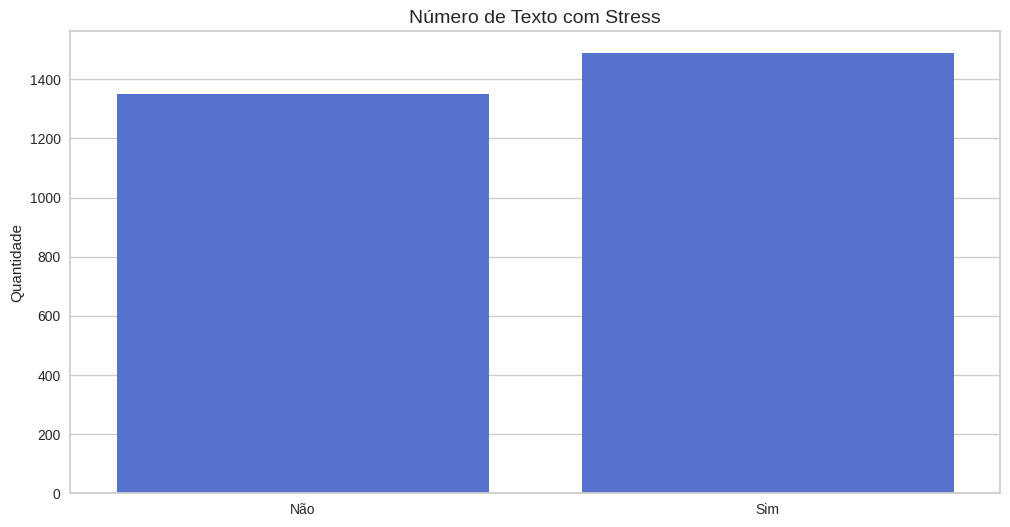

In [6]:
plt.figure(figsize=(12,6))
plt.title('Número de Texto com Stress',fontsize=14)
sns.countplot(x='label',data=stress,color='royalblue')
plt.xlabel('')
plt.xticks([0,1],['Não','Sim'])
plt.ylabel('Quantidade');


Podemos ver pelo gráfico acima que o dataset está de certa forma balanceado e que as labels estão mais ou menos na mesma quantidade, caso se estivesse desbaleceado, ou poderia coletar mais dados ou utilizaria mais técnicas para lidar com o desbalaceamento como *oversampling* ou *undersampling*.

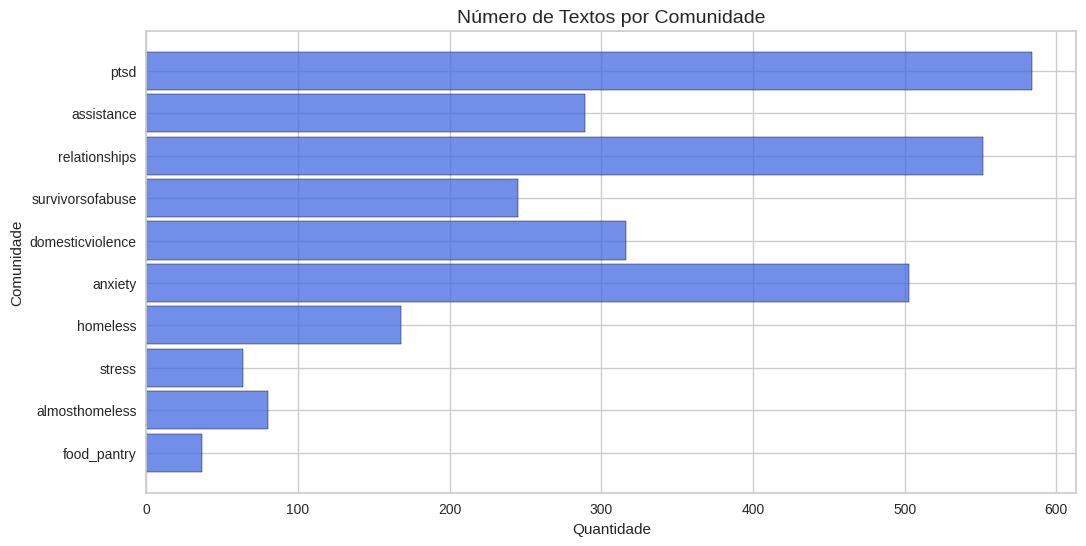

In [7]:
plt.figure(figsize=(12,6))
plt.title('Número de Textos por Comunidade',fontsize=14)
sns.histplot(y='subreddit',data=stress,color='royalblue',shrink=.9)
plt.ylabel('Comunidade')
plt.xlabel('Quantidade');

As três comunidades que tem mais textos é em *ptsd*, *relationships* e *anxiety*.

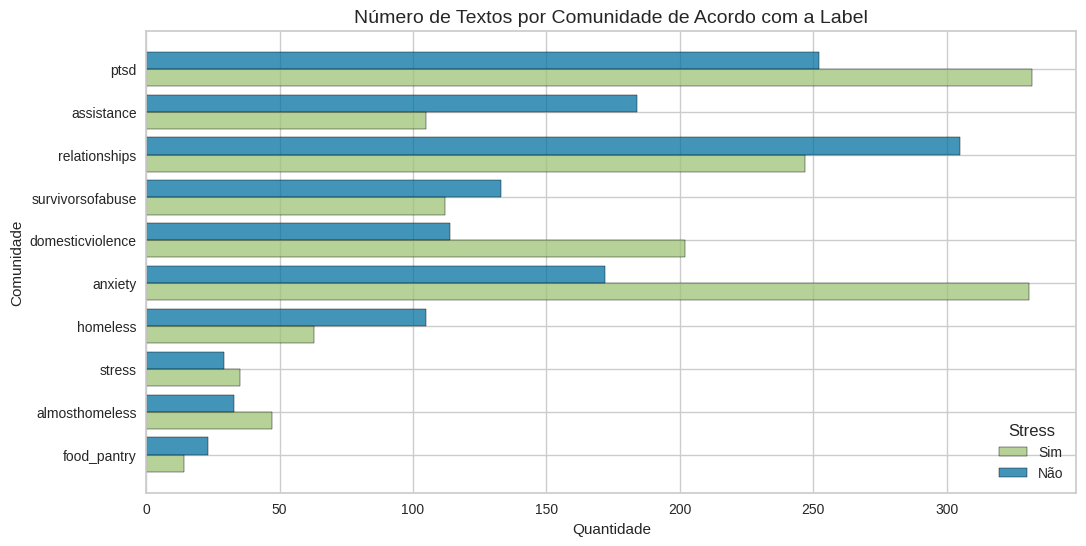

In [8]:
plt.figure(figsize=(12,6))
plt.title('Número de Textos por Comunidade de Acordo com a Label',fontsize=14)
sns.histplot(y='subreddit',data=stress,color='royalblue',hue='label',multiple="dodge",
             shrink=.8)
plt.ylabel('Comunidade')
plt.xlabel('Quantidade')
plt.legend(['Sim','Não'],title='Stress');

Podemos ver que em *anxiety* temos muito mais txtos com stress se compararmos em outros textos como *assistence* por exemplo onde se tem mais texto sem stresse

## Pré-Processamento



In [9]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
def clean(text):                                       # function for cleaning the text column             
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
stress['text'] = stress['text'].apply(clean)

In [11]:
stress.head()

,subreddit,text,label
0,ptsd,said felt way sugget go rest trigger ahead you...,1
1,assistance,hey rassist sure right place post goe im curr...,0
2,ptsd,mom hit newspap shock would know dont like pla...,1
3,relationships,met new boyfriend amaz kind sweet good student...,1
4,survivorsofabuse,octob domest violenc awar month domest violenc...,1


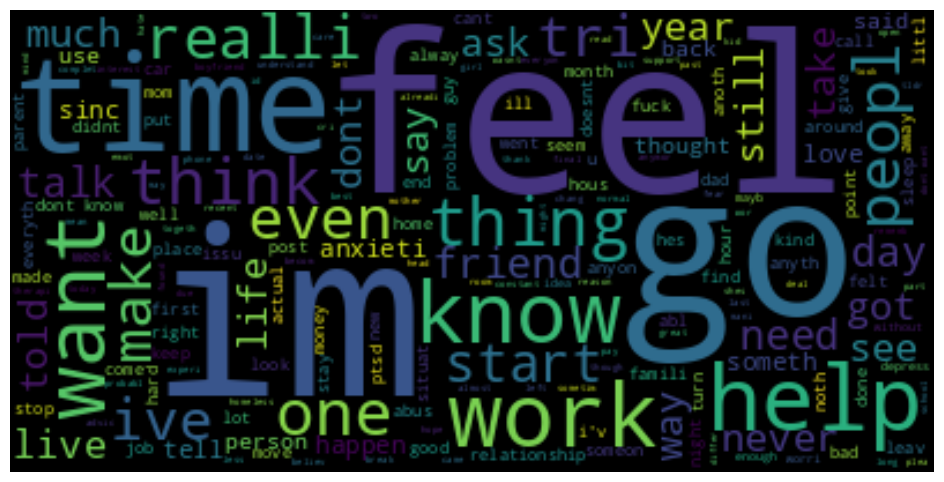

In [12]:
text = " ".join(i for i in stress.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text)
plt.figure( figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Separando por label

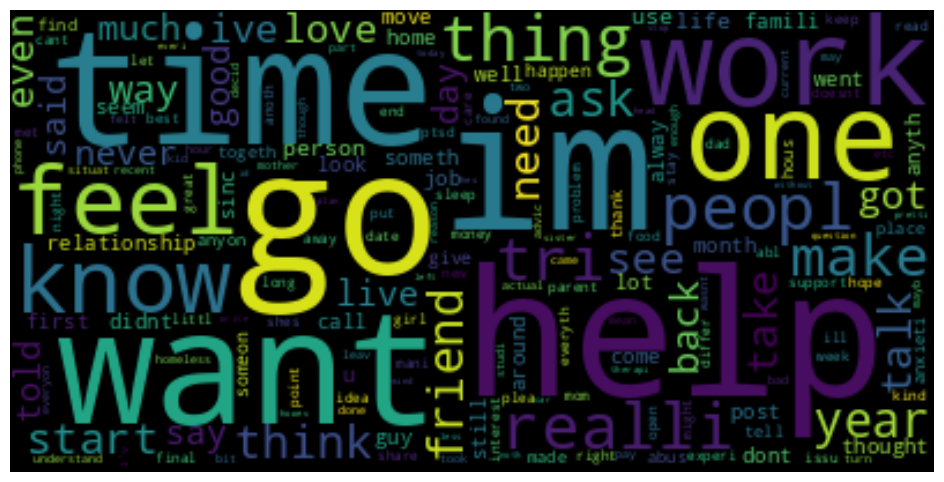

In [13]:
text0 = " ".join(i for i in stress[stress['label']==0]['text'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text0)
plt.figure( figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

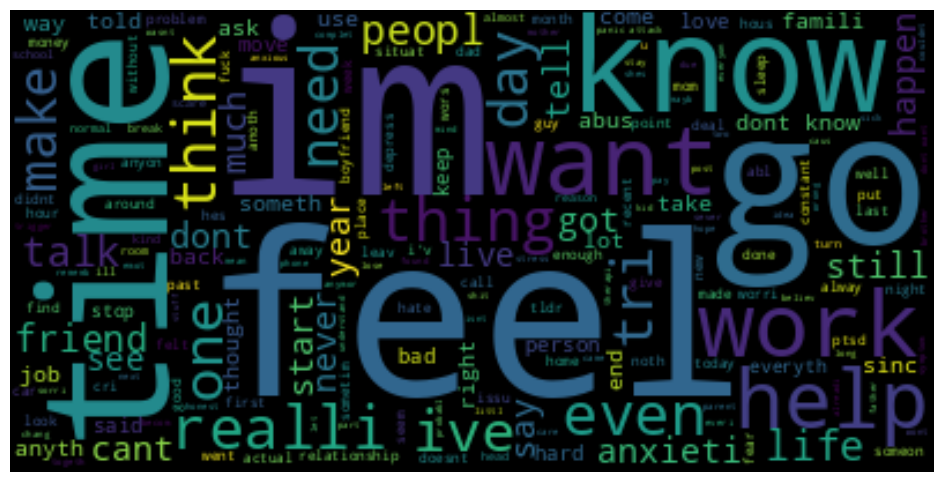

In [14]:
text1 = " ".join(i for i in stress[stress['label']==1]['text'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text1)
plt.figure( figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Comparando os textos dos textos sem stress do que com stress podemos ver que temos termos muito iguais em que provavelmente o modelo não conseguirá uma boa classificação, e que podera de certa forma ser verificada com a modelgem e a comparação dos resultados do modelo.

## Modelagem

In [15]:
cv = CountVectorizer() 
x = cv.fit_transform(stress.text)
y = stress.label

/usr/local/lib/python3.10/dist-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


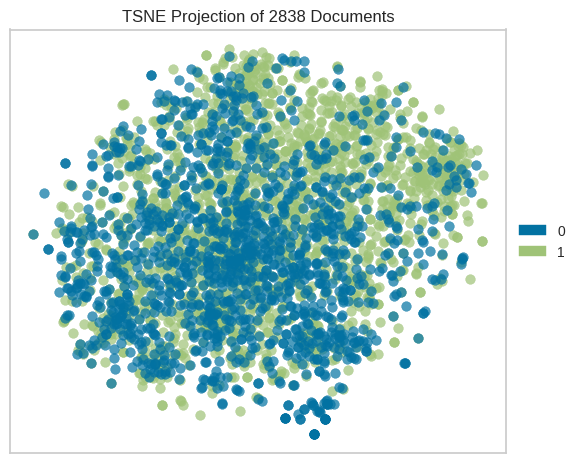

<Axes: title={'center': 'TSNE Projection of 2838 Documents'}>

In [16]:
tsne = TSNEVisualizer()
tsne.fit(x, y)
tsne.show()

Separação dos dados em treino e testo, sendo que 30% foi de teste e o restante foi de treino, em que os resultados que forem obtidos do teste vão ser comparados.

In [17]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                test_size=0.3, 
                                                random_state=42)

Regressão Logistica

In [18]:
rg = LogisticRegression()
rg.fit(x_treino,y_treino)
rg_pred = rg.predict(x_teste)

In [19]:
print(classification_report(y_teste, rg_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7154    0.6618    0.6876       414
           1     0.7015    0.7511    0.7255       438

    accuracy                         0.7077       852
   macro avg     0.7084    0.7065    0.7065       852
weighted avg     0.7083    0.7077    0.7071       852



Knn

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_treino,y_treino)
knn_pred = knn.predict(x_teste)


In [21]:
print(classification_report(y_teste, knn_pred,digits=4))

              precision    recall  f1-score   support

           0     0.5156    0.9565    0.6701       414
           1     0.7857    0.1507    0.2529       438

    accuracy                         0.5423       852
   macro avg     0.6507    0.5536    0.4615       852
weighted avg     0.6545    0.5423    0.4556       852



Svm

In [22]:
svm = SVC(kernel='sigmoid')
svm.fit(x_treino,y_treino)
svm_pred = svm.predict(x_teste)


In [23]:
print(classification_report(y_teste, svm_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7181    0.7198    0.7189       414
           1     0.7346    0.7329    0.7337       438

    accuracy                         0.7265       852
   macro avg     0.7263    0.7263    0.7263       852
weighted avg     0.7265    0.7265    0.7265       852



Naive Bayes

In [24]:
mn = MultinomialNB()
mn.fit(x_treino,y_treino)
mn_pred = mn.predict(x_teste)


In [25]:
print(classification_report(y_teste, mn_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8077    0.6087    0.6942       414
           1     0.7000    0.8630    0.7730       438

    accuracy                         0.7394       852
   macro avg     0.7538    0.7359    0.7336       852
weighted avg     0.7523    0.7394    0.7347       852



Árvore de Decisão

In [26]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(x_treino,y_treino)
tree_pred = tree.predict(x_teste)

In [27]:
print(classification_report(y_teste, tree_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6005    0.5845    0.5924       414
           1     0.6169    0.6324    0.6246       438

    accuracy                         0.6092       852
   macro avg     0.6087    0.6085    0.6085       852
weighted avg     0.6089    0.6092    0.6089       852



Random Forest

In [28]:
rf = RandomForestClassifier(criterion='entropy')
rf.fit(x_treino,y_treino)
rf_pred = rf.predict(x_teste)

In [29]:
print(classification_report(y_teste, rf_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7554    0.5966    0.6667       414
           1     0.6819    0.8174    0.7435       438

    accuracy                         0.7101       852
   macro avg     0.7186    0.7070    0.7051       852
weighted avg     0.7176    0.7101    0.7062       852



Extra Tree

In [30]:
extra_tree = ExtraTreesClassifier(criterion='entropy')
extra_tree.fit(x_treino,y_treino)
extra_tree_pred = extra_tree.predict(x_teste)

In [31]:
print(classification_report(y_teste, extra_tree_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7712    0.5942    0.6712       414
           1     0.6848    0.8333    0.7518       438

    accuracy                         0.7171       852
   macro avg     0.7280    0.7138    0.7115       852
weighted avg     0.7268    0.7171    0.7126       852



Gradiente Boosting

In [32]:
gb = GradientBoostingClassifier()
gb.fit(x_treino,y_treino)
gb_pred = gb.predict(x_teste)

In [33]:
print(classification_report(y_teste, gb_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6992    0.6739    0.6863       414
           1     0.7020    0.7260    0.7138       438

    accuracy                         0.7007       852
   macro avg     0.7006    0.7000    0.7001       852
weighted avg     0.7007    0.7007    0.7005       852



Catboost

In [34]:
cat = CatBoostClassifier()
cat.fit(x_treino,y_treino)
cat_pred = cat.predict(x_teste)

Learning rate set to 0.013809
0:	learn: 0.6920278	total: 77.5ms	remaining: 1m 17s
1:	learn: 0.6904633	total: 101ms	remaining: 50.2s
2:	learn: 0.6892676	total: 124ms	remaining: 41.1s
3:	learn: 0.6881182	total: 148ms	remaining: 36.9s
4:	learn: 0.6868698	total: 175ms	remaining: 34.9s
5:	learn: 0.6853414	total: 198ms	remaining: 32.8s
6:	learn: 0.6838941	total: 221ms	remaining: 31.4s
7:	learn: 0.6822669	total: 249ms	remaining: 30.8s
8:	learn: 0.6807462	total: 272ms	remaining: 30s
9:	learn: 0.6794220	total: 300ms	remaining: 29.7s
10:	learn: 0.6781078	total: 329ms	remaining: 29.6s
11:	learn: 0.6770015	total: 358ms	remaining: 29.5s
12:	learn: 0.6758967	total: 382ms	remaining: 29s
13:	learn: 0.6749257	total: 406ms	remaining: 28.6s
14:	learn: 0.6740784	total: 430ms	remaining: 28.2s
15:	learn: 0.6729829	total: 455ms	remaining: 28s
16:	learn: 0.6718240	total: 481ms	remaining: 27.8s
17:	learn: 0.6707284	total: 512ms	remaining: 27.9s
18:	learn: 0.6699682	total: 537ms	remaining: 27.7s
19:	learn: 0.66

In [35]:
print(classification_report(y_teste, gb_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6992    0.6739    0.6863       414
           1     0.7020    0.7260    0.7138       438

    accuracy                         0.7007       852
   macro avg     0.7006    0.7000    0.7001       852
weighted avg     0.7007    0.7007    0.7005       852



XGboost

In [36]:
xg = XGBClassifier()
xg.fit(x_treino,y_treino)
xg_pred = xg.predict(x_teste)

In [37]:
print(classification_report(y_teste, xg_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6893    0.6377    0.6625       414
           1     0.6802    0.7283    0.7034       438

    accuracy                         0.6843       852
   macro avg     0.6847    0.6830    0.6830       852
weighted avg     0.6846    0.6843    0.6835       852



In [38]:
modelos = ['Regressão logistica','KNN','SVM com Kernel Sigmoid','Naive Bayes (Multinomial)',
           'Árvore de Decisão','Random Forest','Extra Tree','Gradiente Boosting','Xgboost','Catbbost']

acuracia = [accuracy_score(y_teste, rg_pred),accuracy_score(y_teste, knn_pred),accuracy_score(y_teste, svm_pred),
            accuracy_score(y_teste, mn_pred),accuracy_score(y_teste, tree_pred),accuracy_score(y_teste, rf_pred),
            accuracy_score(y_teste, extra_tree_pred),accuracy_score(y_teste, gb_pred),accuracy_score(y_teste, xg_pred),
            accuracy_score(y_teste, cat_pred)]

In [39]:
recall = [recall_score(y_teste, rg_pred),recall_score(y_teste, knn_pred),recall_score(y_teste, svm_pred),
            recall_score(y_teste, mn_pred),recall_score(y_teste, tree_pred),recall_score(y_teste, rf_pred),
            recall_score(y_teste, extra_tree_pred),recall_score(y_teste, gb_pred),recall_score(y_teste, xg_pred),
            recall_score(y_teste, cat_pred)]

f1 = [f1_score(y_teste, rg_pred),f1_score(y_teste, knn_pred),f1_score(y_teste, svm_pred),
            f1_score(y_teste, mn_pred),f1_score(y_teste, tree_pred),f1_score(y_teste, rf_pred),
            f1_score(y_teste, extra_tree_pred),f1_score(y_teste, gb_pred),f1_score(y_teste, xg_pred),
            f1_score(y_teste, cat_pred)]

In [40]:
precision = [precision_score(y_teste, rg_pred),precision_score(y_teste, knn_pred),precision_score(y_teste, svm_pred),
            precision_score(y_teste, mn_pred),precision_score(y_teste, tree_pred),precision_score(y_teste, rf_pred),
            precision_score(y_teste, extra_tree_pred),  precision_score(y_teste, gb_pred), precision_score(y_teste, xg_pred),
              precision_score(y_teste, cat_pred)]

In [41]:
metrica = {'Nome do Modelo':modelos,'Acc':acuracia,'Pre':precision,'Rec':recall,'F1':f1}

## Sobre as métricas de classificação

A fonte para essa explicação pode ser acessado [aqui](https://medium.com/kunumi/métricas-de-avaliação-em-machine-learning-classificação-49340dcdb198).

As métricas de clasicação são obtidas a partir da matriz de confusão, que permite visualizar facilmente quantos exemplos foram classificados corretamente e erroneamente em cada classe, ajudando a entender se o modelo está favorecendo uma classe em detrimento da outra.

![image](https://user-images.githubusercontent.com/39843884/233479442-ca499fe8-8701-4885-aaf9-09efa108148a.png)

As partir disso pode-se obter as seguintes métricas:

- **Acurácia**: nos diz quantos de nossos exemplos foram de fato classificados corretamente, independente da classe. 

![image](https://user-images.githubusercontent.com/39843884/233480442-e9f368c5-e35c-4106-9d48-589da41bd757.png)

Uma das maiores desvantagens é que em alguns problemas a acurácia pode ser elevada mas, ainda assim, o modelo pode ter uma performance inadequada. Por isso outras métricas são utilizadas para verificar se o modelo facilitou um determinada classe.

- **Precisão**:  Esta métrica é definida pela razão entre a quantidade de exemplos classificados corretamente como positivos e o total de exemplos classificados como positivos. 


![image](https://user-images.githubusercontent.com/39843884/233481000-ef813924-e9fd-460b-b81b-fef58f463aee.png)

- **Recall**: Também chamdo de Revocação ,dá maior ênfase para os erros por falso negativo. Esta métrica é definida pela razão entre a quantidade de exemplos classificados corretamente como positivos e a quantidade de exemplos que são de fato positivos. 

![image](https://user-images.githubusercontent.com/39843884/233481646-43deaaa7-5fc7-406b-b445-f2e910b3b0a3.png)

- **F1-Score**: Leva em consideração tanto a precisão quanto a revocação. Ela é definida pela média harmônica entre as duas.Se a precisão ou a revocação for zero ou muito próximos disso, o F1-score também será baixo. Desta forma, para que o F1-score seja alto, tanto a precisão como a revocação também devem ser altas.


![image](https://user-images.githubusercontent.com/39843884/233481977-1e82a022-badb-4152-9a6d-ff0f390443eb.png)

In [42]:
pd.DataFrame(metrica)

,Nome do Modelo,Acc,Pre,Rec,F1
0,Regressão logistica,0.707746,0.701493,0.751142,0.725469
1,KNN,0.542254,0.785714,0.150685,0.252874
2,SVM com Kernel Sigmoid,0.726526,0.734554,0.732877,0.733714
3,Naive Bayes (Multinomial),0.739437,0.700000,0.863014,0.773006
4,Árvore de Decisão,0.609155,0.616927,0.632420,0.624577
5,Random Forest,0.710094,0.681905,0.817352,0.743510
6,Extra Tree,0.717136,0.684803,0.833333,0.751802
7,Gradiente Boosting,0.700704,0.701987,0.726027,0.713805
8,Xgboost,0.684272,0.680171,0.728311,0.703418
9,Catbbost,0.717136,0.720358,0.735160,0.727684


# Consideraçẽs Finais

Comparando as métircas, podemos ver que:

- Comparando as métricas, podemos ver que os modelos com melhor perfomace foram  *Multinomial NB* (naive bayes), *SVM* com kernel sigmoid, e o *Catboost*.

- Poderia ser feito o metodo embbeding na tokenização;

- Fazer o cross-validation para comparar o resultado de vários testes.

![image](https://user-images.githubusercontent.com/39843884/233484847-7c15a251-c252-497d-a244-3b67e3ffc5e8.png)

- Fazer uma maior investigação pra ver se existem termos que tem mais uma classe do que outro.

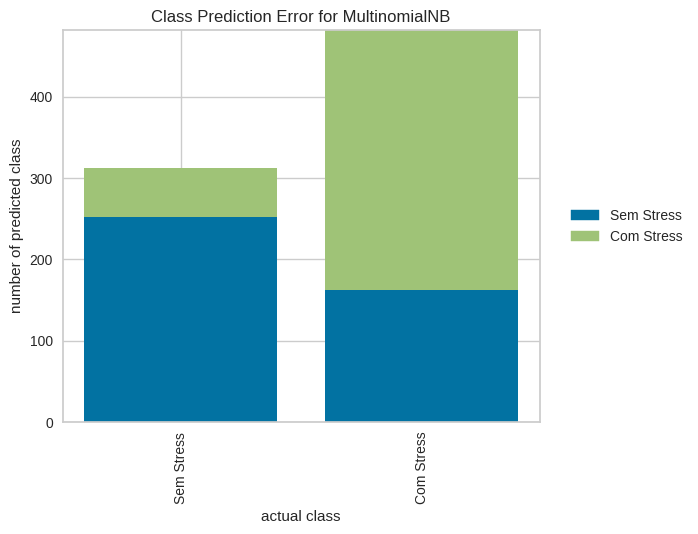

<Axes: title={'center': 'Class Prediction Error for MultinomialNB'}, xlabel='actual class', ylabel='number of predicted class'>

In [48]:

classes = ['Sem Stress', 'Com Stress']

visualizer = ClassPredictionError(
    mn, classes=classes)
visualizer.fit(x_treino, y_treino)
visualizer.score(x_teste, y_teste)
visualizer.show()

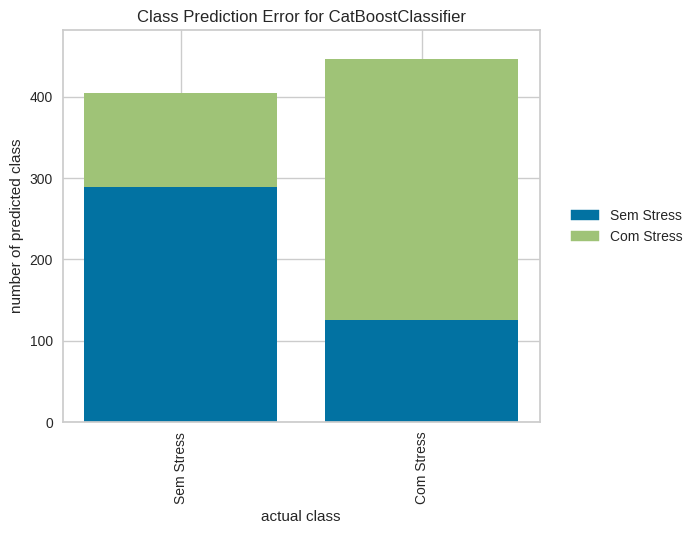

<Axes: title={'center': 'Class Prediction Error for CatBoostClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [50]:

model = wrap(cat)
visualizer = ClassPredictionError(model,classes=classes)
visualizer.fit(x_treino, y_treino)
visualizer.score(x_teste, y_teste)
visualizer.show()

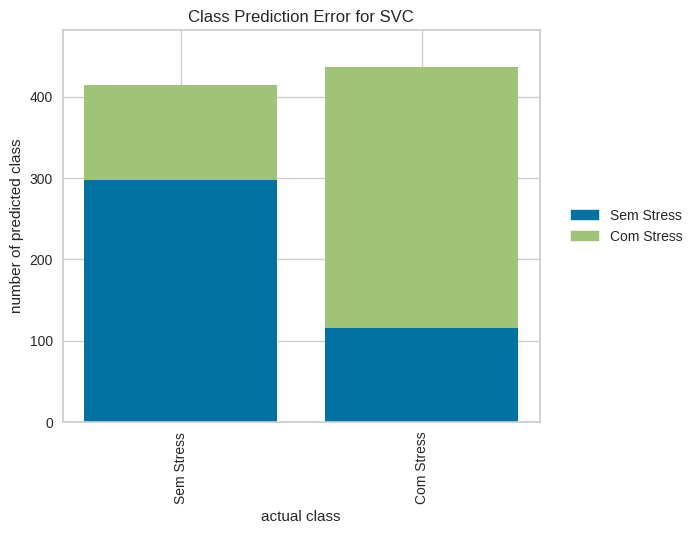

<Axes: title={'center': 'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>

In [51]:
visualizer = ClassPredictionError(
    svm,classes=classes)
visualizer.fit(x_treino, y_treino)
visualizer.score(x_teste, y_teste)
visualizer.show()